In [12]:
## This notebook is an investigation of different data sets/data types with regards to 
## Monitoring Living Shorelines

In [13]:
## Importing Libraries 
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs


In [14]:
# Read a shapefile of NYC's shoreline. This data set was retrieved from (Insert Link)

local_path = "/Users/kenneth/Documents/Living_Shorelines/data/nyc_gov_shoreline/nyc_shoreline.shp" #This is where the copy of the remote repository was cloned onto the local computer(varies from user to user)

nyc_shoreline = gpd.read_file(local_path) # reading the data and storing it as a geopandas dataframe 

In [15]:
# creating a simple plot of the geopandas dataframe 
nyc_shoreline.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   feat_code   489 non-null    float64 
 1   shape_leng  489 non-null    float64 
 2   source_id   489 non-null    float64 
 3   status      489 non-null    object  
 4   sub_code    489 non-null    float64 
 5   geometry    489 non-null    geometry
dtypes: float64(4), geometry(1), object(1)
memory usage: 23.0+ KB


In [16]:
nyc_shoreline.head(1)

,feat_code,shape_leng,source_id,status,sub_code,geometry
0,3900.0,482.569042,2.139000e+10,Unchanged,390000.0,"LINESTRING (-73.99730 40.70118, -73.99733 40.7..."


In [17]:
##importing data from census to look at census tracts 
## https://www.nyc.gov/site/planning/data-maps/open-data.page#census
file_path = "/Users/kenneth/Documents/Living_Shorelines/data/census_tracts_2020/nyct2020.shp"
nyc_census_tracts = gpd.read_file(file_path)

In [18]:
## cleaning data, selecting only columns of interest and converting data types to 
## the desired types 
nyc_census_tracts = nyc_census_tracts[['BoroName','GEOID','geometry']]
nyc_census_tracts['GEO_ID'] = nyc_census_tracts['GEOID'].astype(int)

<AxesSubplot:>

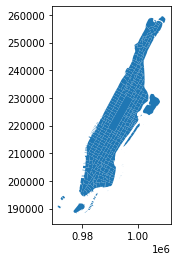

In [19]:
## creating a mask that marks the row as true if the value in the boro name column is manhattan
##applying the mask onto the entire dataframe-- this will select only the manhattan rows
##plotting the census tracts 
mask = nyc_census_tracts['BoroName'] == 'Manhattan'
manhattan = nyc_census_tracts.loc[mask]
manhattan.plot()

In [20]:
## Importing data from American Community Survey for Per Capita Income(future work, left on 07/10/23)
## https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [21]:
## Importing poverty/POPULATION data from American Community Survey(Census tract data 2021)
file_path = "/Users/kenneth/Documents/Living_Shorelines/data/census_tracts_2020/socioeconomic_data/2021_B17001.csv"
nyc_poverty = pd.read_csv(file_path, low_memory=False)

In [22]:
## cleaning the data so that we only have GEO_ID, poverty, and population data columns
## Dropping first row of data as it is metadata/extra titles 

nyc_poverty = nyc_poverty[['GEO_ID','B17001_001E','B17001_002E']] # selecting on columns of interest
nyc_poverty = nyc_poverty.iloc[1: , :] # dropping first row 
nyc_poverty['B17001_001E'] = nyc_poverty['B17001_001E'].astype(int) # turning column into intergers 
nyc_poverty['B17001_002E'] = nyc_poverty['B17001_002E'].astype(int) # turning column into intergers 
nyc_poverty['GEO_ID'] = nyc_poverty['GEO_ID'].apply(lambda x: x[9:]) #dropping country code from GEOID
nyc_poverty['GEO_ID'] = nyc_poverty['GEO_ID'].astype(int) # turning column into intergers 

nyc_poverty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 1 to 2327
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   GEO_ID       2327 non-null   int64
 1   B17001_001E  2327 non-null   int64
 2   B17001_002E  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [23]:
nyc_poverty.head()

,GEO_ID,B17001_001E,B17001_002E
1,36005000100,0,0
2,36005000200,4453,1014
3,36005000400,6000,240
4,36005001600,5826,951
5,36005001901,2164,596


In [24]:
## lets create a poverty ratio index(ie what percentage of the population is living 
## in poverty)

nyc_poverty['percent_poverty'] = (nyc_poverty['B17001_002E'] / nyc_poverty['B17001_001E']) * 100

In [25]:
## merging the poverty dataframe with the census tract geodataframe
## this will allow us to access the poverty data geospatially 
nyc_poverty_gpd =  pd.merge(
    left = nyc_census_tracts,
    right = nyc_poverty,
    how="inner",
    on='GEO_ID')

<AxesSubplot:>

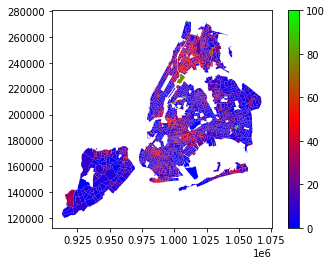

In [26]:
nyc_poverty_gpd.plot("percent_poverty", cmap="brg", legend = True) 

In [27]:
def boro_plotter(gpd, boro):
    mask2 = gpd['BoroName'].eq(boro)
    boro_to_be_plotted = gpd.loc[mask2]
    boro_to_be_plotted.plot("percent_poverty", cmap="brg", legend=True)

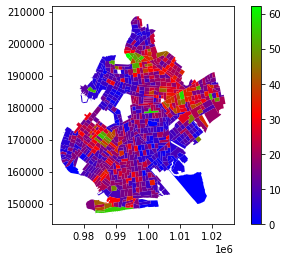

In [28]:
boro_plotter(gpd=nyc_poverty_gpd, boro = 'Brooklyn')

In [29]:
## Vulnerability Mapping

In [30]:
##importing data from census to look at census tracts 
## https://www.nyc.gov/site/planning/data-maps/open-data.page#census
#file_path = "/Users/kenneth/Downloads/wastewater_treatment_plants/wastewater_treatment_plants.shp"
#test = gpd.read_file(file_path)

In [31]:
## Importing vulnerabilty data from CDC
## https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html
file_path = "/Users/kenneth/Documents/Living_Shorelines/data/census_tracts_2020/socioeconomic_data/vulnerability.csv"
nyc_vuln = pd.read_csv(file_path, low_memory=False)

In [33]:
## selecting columns of interest and
## turning -999 values into NAN values because -999 
## According to the documentation: https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html
## "For tracts with > 0 TOTPOP, a value of -999 in any field either means the value was unavailable 
## from the original census data or we could not calculate a derived value because of unavailable census data."
nyc_vuln = nyc_vuln[['COUNTY', 'FIPS', 'RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4','RPL_THEMES']]
nyc_vuln.loc[nyc_vuln['RPL_THEMES'] == -999, 'RPL_THEMES'] = np.nan
nyc_vuln.loc[nyc_vuln['RPL_THEME1'] == -999, 'RPL_THEME1'] = np.nan
nyc_vuln.loc[nyc_vuln['RPL_THEME2'] == -999, 'RPL_THEME2'] = np.nan
nyc_vuln.loc[nyc_vuln['RPL_THEME3'] == -999, 'RPL_THEME3'] = np.nan


In [34]:
## lets try to merge with the NYC shapefile!
## This will allow us to access the vulnerabilty data within a geopandas dataframe object 

nyc_vuln_gpd = pd.merge(nyc_census_tracts, nyc_vuln, left_on='GEO_ID', right_on='FIPS')

In [73]:
nyc_vuln_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroName    2324 non-null   object  
 1   GEOID       2324 non-null   object  
 2   geometry    2324 non-null   geometry
 3   GEO_ID      2324 non-null   int64   
 4   COUNTY      2324 non-null   object  
 5   FIPS        2324 non-null   int64   
 6   RPL_THEME1  2234 non-null   float64 
 7   RPL_THEME2  2237 non-null   float64 
 8   RPL_THEME3  2241 non-null   float64 
 9   RPL_THEME4  2324 non-null   float64 
 10  RPL_THEMES  2227 non-null   float64 
dtypes: float64(5), geometry(1), int64(2), object(3)
memory usage: 217.9+ KB


In [35]:
## modifying boro plotting function so that I can decide what variable to plot now that the data has multiple variables
def boro_plotter2(gpd, boro, var):
    mask2 = gpd['BoroName'].eq(boro)
    boro_to_be_plotted = gpd.loc[mask2]
    boro_to_be_plotted.plot(var, cmap="brg", legend=True)

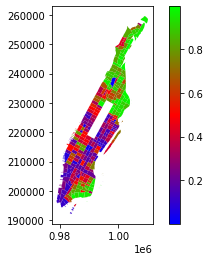

In [36]:
boro_plotter2(gpd = nyc_vuln_gpd, boro = 'Manhattan', var = 'RPL_THEMES' )

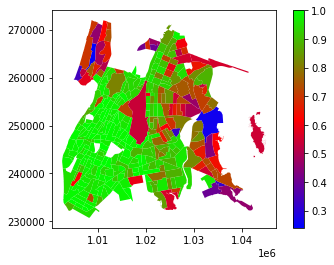

In [37]:
boro_plotter2(gpd = nyc_vuln_gpd, boro = 'Bronx', var = 'RPL_THEMES' )

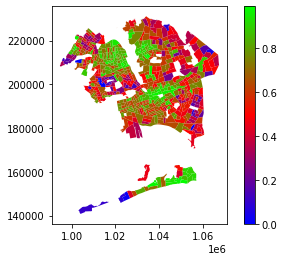

In [38]:
boro_plotter2(gpd = nyc_vuln_gpd, boro = 'Queens', var = 'RPL_THEMES' )

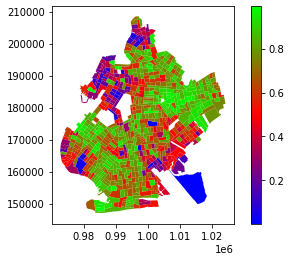

In [39]:
boro_plotter2(gpd = nyc_vuln_gpd, boro = 'Brooklyn', var = 'RPL_THEMES' )

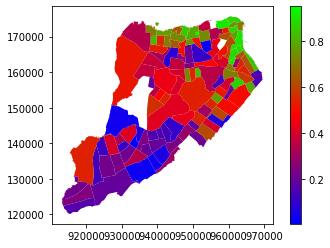

In [40]:
boro_plotter2(gpd = nyc_vuln_gpd, boro = 'Staten Island', var = 'RPL_THEMES' )

<AxesSubplot:>

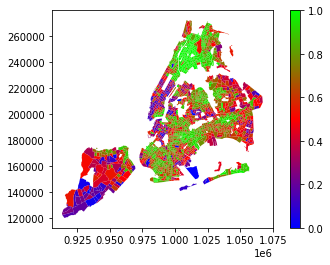

In [41]:
nyc_vuln_gpd.plot("RPL_THEMES", cmap="brg", legend = True) 

##  Environmental Justice Maps 

In [76]:
## Importing environmental justice data from CDC
## https://www.atsdr.cdc.gov/placeandhealth/eji/docs/EJI-2022-Documentation.pdf
## ['RPL_EJI'] is the environmental justice index column
file_path = "/Users/kenneth/Documents/Living_Shorelines/data/census_tracts_2020/socioeconomic_data/environmental_justice.csv"
nyc_ej = pd.read_csv(file_path, low_memory=False)


In [77]:
nyc_ej = nyc_ej[['COUNTY','GEOID','RPL_EJI', 'SPL_EJI']]

In [78]:
nyc_ej

,COUNTY,GEOID,RPL_EJI,SPL_EJI
0,Albany,36001000100,0.9371,2.4208
1,Albany,36001000200,0.9329,2.4031
2,Albany,36001000300,0.9794,2.6183
3,Albany,36001000401,0.4914,1.2418
4,Albany,36001000403,0.5636,1.3784
...,...,...,...,...
4901,Yates,36123150100,0.7569,1.8208
4902,Yates,36123150200,0.6358,1.5307
4903,Yates,36123150300,0.4307,1.1343
4904,Yates,36123150400,0.1669,0.6635


In [79]:
nyc_ej_gpd = pd.merge(nyc_census_tracts, nyc_ej, left_on='GEO_ID', right_on='GEOID')







In [80]:
nyc_ej_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2033 entries, 0 to 2032
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   BoroName  2033 non-null   object  
 1   GEOID_x   2033 non-null   object  
 2   geometry  2033 non-null   geometry
 3   GEO_ID    2033 non-null   int64   
 4   COUNTY    2033 non-null   object  
 5   GEOID_y   2033 non-null   int64   
 6   RPL_EJI   1978 non-null   float64 
 7   SPL_EJI   1978 non-null   float64 
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 142.9+ KB


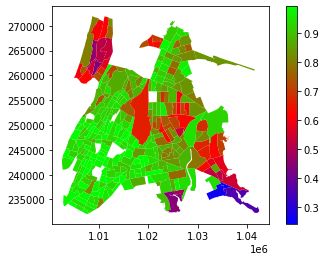

In [67]:
boro_plotter2(gpd = nyc_ej_gpd, boro = 'Bronx', var = 'RPL_EJI' )







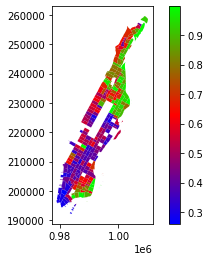

In [68]:
boro_plotter2(gpd = nyc_ej_gpd, boro = 'Manhattan', var = 'RPL_EJI' )

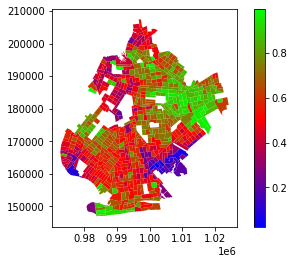

In [69]:
boro_plotter2(gpd = nyc_ej_gpd, boro = 'Brooklyn', var = 'RPL_EJI' )

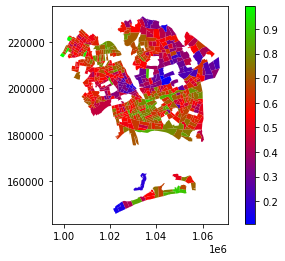

In [70]:
boro_plotter2(gpd = nyc_ej_gpd, boro = 'Queens', var = 'RPL_EJI' )